* Run sdf_2pkls.py first. 
* _mols.pkl, _names.pkl, _smiles.pkl, fps.pkl files are generated. 
* There are loaded here.
* Parallel search is applied.

In [2]:
import rdkit
from rdkit import Chem

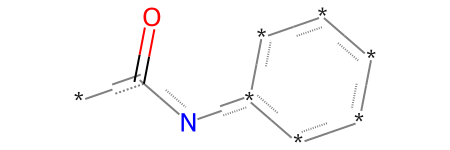

In [3]:
# Kekulized SMILES cannot recognize the aromatic SMILES, but vice versa is possible.
smarts = '[*]C(N[*]1[*][*][*][*][*]1)=O'  
query = Chem.MolFromSmarts(smarts)
query

In [4]:
mols_file = 'samples_mols.pkl'
names_file = 'samples_names.pkl'

import pickle
with open(mols_file, "rb") as f:
    mols = pickle.load(f)

with open(names_file, "rb") as f:
    names = pickle.load(f)

print(len(mols), len(names))

5440 5440


In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from rdkit.Chem import MolToInchiKey

# CPU 갯수 구하기
num_cpus = 8 # cpu_count() // 4

# mols 리스트를 CPU 갯수만큼 나누기
mols_per_cpu = len(mols) // 80 # (num_cpus*10)
mols_list = [mols[i:i+mols_per_cpu] for i in range(0, len(mols), mols_per_cpu)]

# 병렬 처리
results = Parallel(n_jobs=num_cpus, verbose=10)(delayed(lambda mols_chunk: [mol.HasSubstructMatch(query) for mol in mols_chunk])(mols_chunk) for mols_chunk in mols_list)

# 결과 순서대로 정렬
matched_indices = []
for i in range(0, len(mols), mols_per_cpu):
    matched_indices += results[i//mols_per_cpu]
matched_mols = [mols[i] for i in range(len(mols)) if matched_indices[i]]

# matched_indices에 있는 인덱스 값에 해당하는 값을 찾아서 리스트로 저장
matched_names = [names[i] for i in range(len(mols)) if matched_indices[i]]

# 인치키 생성
from rdkit.Chem import SmilesWriter
matched_keys = [MolToInchiKey(mol) for mol in matched_mols]

print(len(matched_mols))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Batch computation too fast (0.18240735342912703s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Batch computation too fast (0.04934191703796387s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  74 out of  80 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.6s finished


2615


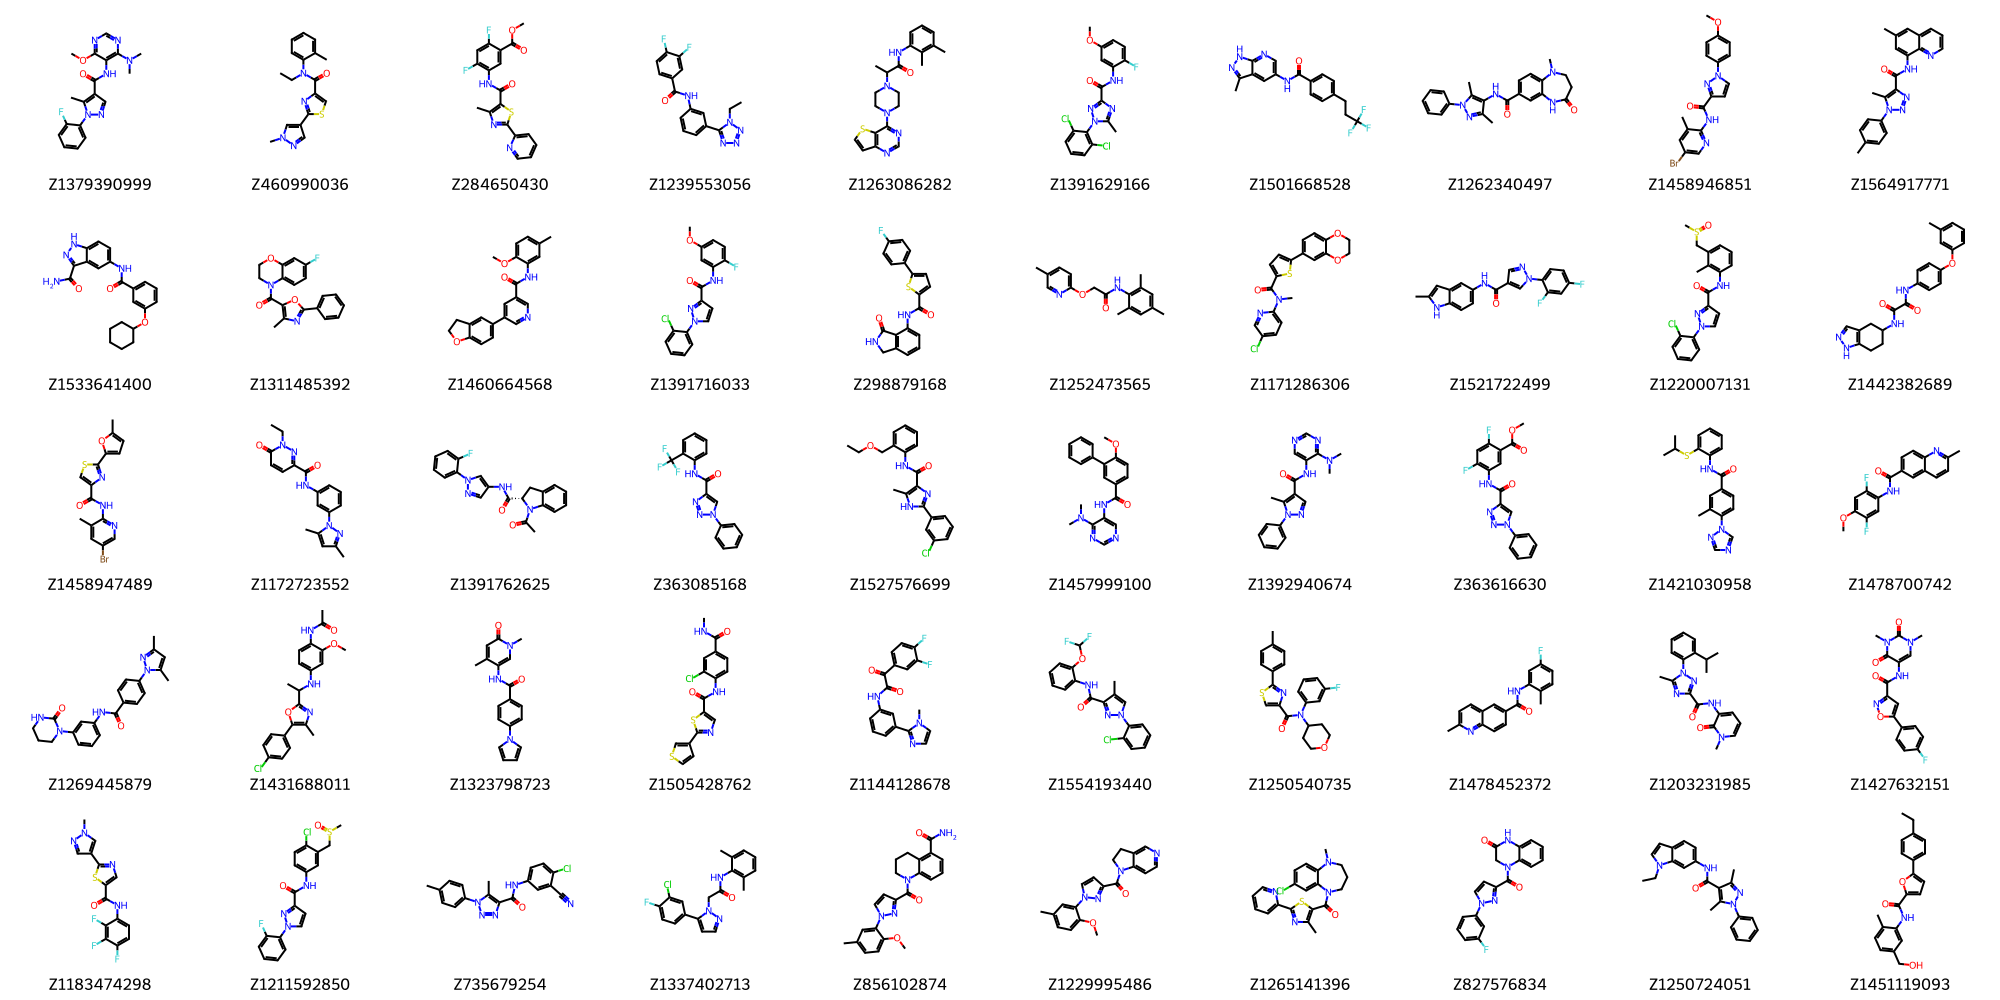

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# 이미지 출력
IPythonConsole.ipython_useSVG=True
img = Draw.MolsToGridImage(matched_mols[:50], molsPerRow=10, subImgSize=(200, 200), legends=matched_names, maxMols=50)
img

In [8]:
from rdkit.Chem import MolToSmiles
import csv

# csv 파일 저장
with open('matched_molecules.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'smiles', 'inchikey'])
    for name, mol, key in zip(matched_names, matched_mols, matched_keys):
        writer.writerow([name, MolToSmiles(mol), key])